# Q3. Regression

In [30]:
import jax.numpy as jnp
from numpy.random import randn
from random import randint
from jax import random, grad
from matplotlib import pyplot as plt

In [2]:
def generate_random_seed():
    return randint(0, 10000)

In [3]:
def target_f1(x, sigma_true=0.3):
    key = random.PRNGKey(generate_random_seed())
    noise = random.normal(key, shape=x.shape)
    
    return (2 * x + sigma_true * noise).ravel()

In [14]:
def norm(a: float):
    return (a * a) ** 0.5

def element_wise_norm(x):
    shape = x.shape
    return jnp.array([norm(el) for el in x.ravel()]).reshape(shape)
  
def element_wise_sin(x):
    shape = x.shape

    return jnp.sin(x.ravel()).reshape(shape)


In [5]:
def target_f2(x: jnp.ndarray):
    key = random.PRNGKey(generate_random_seed())
    noise = random.normal(key, shape=x.shape)
    y = 2 * x + element_wise_norm(x) * 0.3 * noise
    
    return y.ravel()

In [6]:
def target_f3(x):
    key = random.PRNGKey(generate_random_seed())
    noise = random.normal(key, shape=x.shape)
    y = 2 * x + 5 * element_wise_sin(x * 0.5) + element_wise_norm(x) * 0.3 * noise
    
    return y.ravel()

## Sample data from the target functions 

In [7]:
def sample_batch(target_f, batch_size):
    key = random.PRNGKey(generate_random_seed())
    x = random.uniform(key, shape=(1, batch_size), minval=0., maxval=20.)
    y = target_f(x)
    
    return x, y

## Test assumptions about your dimensions

In [35]:
n = 200
m = 1

for target_f in [target_f1, target_f2, target_f3]:
    x, y = sample_batch(target_f, n)
    assert x.shape == (m, n)
    assert y.shape == (n,)

print('Yaay!')

Yaay!


## Plot the target functions

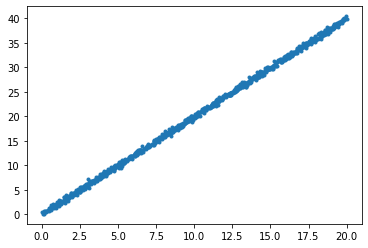

In [36]:
x, y = sample_batch(target_f1, 1000)

plt.plot(x[0], y, '.');

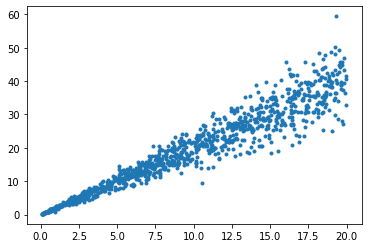

In [37]:
x, y = sample_batch(target_f2, 1000)

plt.plot(x[0], y, '.');

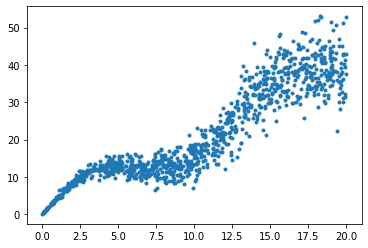

In [38]:
x, y = sample_batch(target_f3, 1000)

plt.plot(x[0], y, '.');

## Linear regression model with $\hat{\beta}$ MLE

In [12]:
from jax.numpy.linalg import inv

def beta_mle(X, y):
    beta = inv(X.dot(X.T)) @ X @ y
    
    return beta

In [13]:
n = 1000

print(beta_mle(*sample_batch(target_f1, n)))

[2.00003]


In [14]:
n = 1000

print(beta_mle(*sample_batch(target_f2, n)))

[1.9851127]


In [15]:
n = 1000

print(beta_mle(*sample_batch(target_f3, n)))

[2.0806715]


## Plot the MLE linear regression model

In [16]:
n = 200
X, y = sample_batch(target_f1, n)
beta_hat = beta_mle(X, y)
y_hat = (X.T @ beta_hat).ravel()

In [20]:
def sort_data(X, y, y_hat):
    """
    Due to the problem I had with shading I had to sort the data first and then
    plot the results...
    """
    order = jnp.argsort(X)

    return X[order], y[order], y_hat[order]

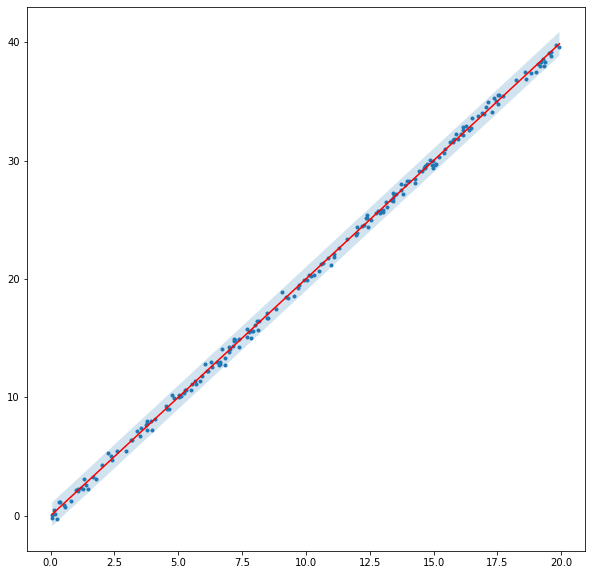

In [18]:
X_sorted, y_sorted, y_hat_sorted = sort_data(X[0], y, y_hat)

plt.figure(figsize=(10, 10))
plt.plot(X_sorted, y_sorted, '.');
plt.plot(X_sorted, y_hat_sorted, 'r');
uncertainty = [1.] * len(y_hat_sorted)
plt.fill_between(X_sorted, y_hat_sorted.copy()-uncertainty, y_hat_sorted.copy()+uncertainty, alpha=0.2);

In [19]:
n = 200
X, y = sample_batch(target_f2, n)
beta_hat = beta_mle(X, y)
y_hat = (X.T @ beta_hat).ravel()

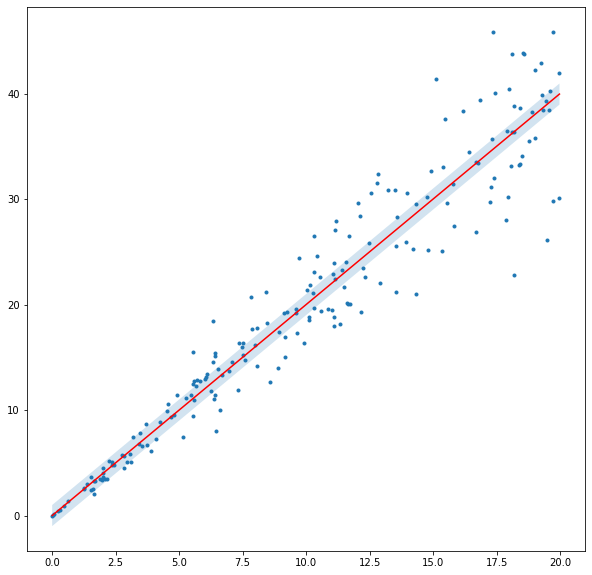

In [20]:
X_sorted, y_sorted, y_hat_sorted = sort_data(X[0], y, y_hat)
plt.figure(figsize=(10, 10))
plt.plot(X_sorted, y_sorted, '.');
plt.plot(X_sorted, y_hat_sorted, 'r');
uncertainty = [1.] * len(y_hat_sorted)
plt.fill_between(X_sorted, y_hat_sorted.copy()-uncertainty, y_hat_sorted.copy()+uncertainty, alpha=0.2);

In [21]:
n = 200
X, y = sample_batch(target_f3, n)
beta_hat = beta_mle(X, y)
y_hat = (X.T @ beta_hat).ravel()

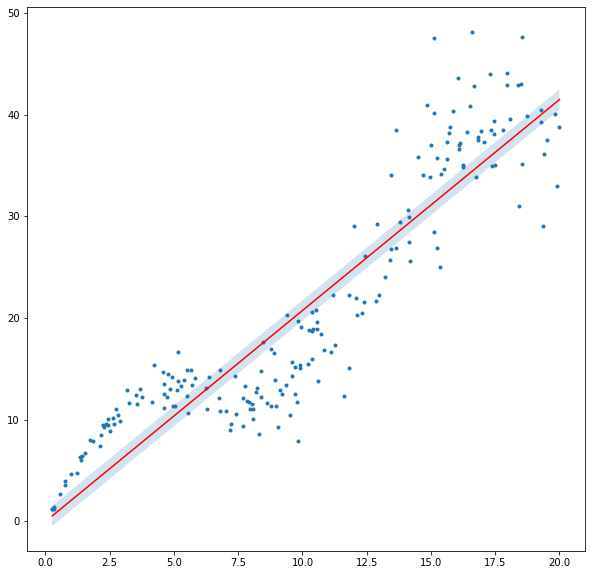

In [22]:
X_sorted, y_sorted, y_hat_sorted = sort_data(X[0], y, y_hat)
plt.figure(figsize=(10, 10))
plt.plot(X_sorted, y_sorted, '.');
plt.plot(X_sorted, y_hat_sorted, 'r');
uncertainty = [1.] * len(y_hat_sorted)
plt.fill_between(X_sorted, y_hat_sorted.copy()-uncertainty, y_hat_sorted.copy()+uncertainty, alpha=0.2);

## Log-likelihood of Data under Model

In [8]:
from math import pi

def gaussian_log_likelihood(mu, sigma, x):    
    return -0.5 * jnp.log(2 * pi) - jnp.log(sigma) - 0.5 * ((x - mu) / sigma) ** 2


## Test Gaussian likelihood against standard implementation

In [9]:
from jax.scipy.stats import norm

x = np.random.randn()
mu = np.random.randn()
sigma = np.random.rand()
assert gaussian_log_likelihood(mu, sigma, x).shape == ()
assert abs(gaussian_log_likelihood(mu, sigma, x) - norm.logpdf(x, mu, sigma)) < 1e-2

x = np.random.randn(100)
mu = np.random.randn()
sigma = np.random.rand()
assert gaussian_log_likelihood(mu, sigma, x).shape == (100,)
assert np.linalg.norm(gaussian_log_likelihood(mu, sigma, x) - norm.logpdf(x, mu, sigma)) < 1e-2

x = np.random.randn(10)
mu = np.random.randn(10)
sigma = np.random.rand(10)
assert gaussian_log_likelihood(mu, sigma, x).shape == (10,)
assert np.linalg.norm(gaussian_log_likelihood(mu, sigma, x) - norm.logpdf(x, mu, sigma)) < 1e-2

print('Yaay!')

Yaay!


## Model Negative Log-likelihood

In [10]:
def lr_model_nll(beta, X, y, sigma):
    """
    This function takes the average nll loss not the sum!
    """
    return -jnp.mean(gaussian_log_likelihood(X.T.dot(beta), sigma, y))

## Compute Negative-Log-Likelihood on data

In [15]:
for n in [10, 100, 1000]:
    print("-------", n, "------")
    for i, target_f in enumerate([target_f1, target_f2, target_f3], 1):
        print(f"target_f{i}:")
        for sigma_model in [0.1, 0.3, 1., 2.]:
            X, y = sample_batch(target_f, n)
            beta = beta_mle(X, y)
            nll = lr_model_nll(beta, X, y, sigma_model)
            print(f'Negative Log-likelihood (sigma={sigma_model}):', nll)
        print()

------- 10 ------
target_f1:
Negative Log-likelihood (sigma=0.1): 3.0840688
Negative Log-likelihood (sigma=0.3): 0.058412135
Negative Log-likelihood (sigma=1.0): 0.9527103
Negative Log-likelihood (sigma=2.0): 1.6253029

target_f2:
Negative Log-likelihood (sigma=0.1): 18.992615
Negative Log-likelihood (sigma=0.3): 87.8604
Negative Log-likelihood (sigma=1.0): 4.381679
Negative Log-likelihood (sigma=2.0): 2.0206194

target_f3:
Negative Log-likelihood (sigma=0.1): 1068.7898
Negative Log-likelihood (sigma=0.3): 68.174416
Negative Log-likelihood (sigma=1.0): 5.471425
Negative Log-likelihood (sigma=2.0): 5.4330153

------- 100 ------
target_f1:
Negative Log-likelihood (sigma=0.1): 4.108435
Negative Log-likelihood (sigma=0.3): 0.17373458
Negative Log-likelihood (sigma=1.0): 0.971069
Negative Log-likelihood (sigma=2.0): 1.6253384

target_f2:
Negative Log-likelihood (sigma=0.1): 582.2185
Negative Log-likelihood (sigma=0.3): 45.583046
Negative Log-likelihood (sigma=1.0): 7.913444
Negative Log-lik

## Effect of model variance

**For each target function what is the best choice of sigma?**

## Automatic differentiation and maximum likelihood

## Compute gradients with AD, Test against hand-derived

In [16]:
key = random.PRNGKey(generate_random_seed())
key, subkey = random.split(key)

beta_test = random.normal(subkey, shape=(1,))

key, subkey = random.split(key)
sigma_test = random.normal(subkey)

X, y = sample_batch(target_f1, 100)
grad_fn = grad(lr_model_nll, argnums=0)

ad_grad = grad_fn(beta_test, X, y, sigma_test)
hand_derivative = 0.01 * 1/(sigma_test ** 2) * (X @ X.T @ beta_test - X @ y)

assert (ad_grad - hand_derivative).item() < 1e-2
print('Yaay!')

Yaay!


## Train linear regression model with gradient descent

In [17]:
def train_lin_reg(target_f, beta_init, bs=100, lr=1e-6, iters=1000, sigma_model=1., 
                  print_every=1000):
    beta_curr = beta_init
    
    grad_fn = grad(lr_model_nll, argnums=0)
    
    for i in range(iters):
        X, y = sample_batch(target_f1, 1000)
        loss = lr_model_nll(beta_curr, X, y, sigma_model)
        if i % print_every == 0:
            print(f'iteration {i}, loss: {loss}, beta: {beta_curr}')
        grad_beta = grad_fn(beta_curr, X, y, sigma_model)
        beta_curr = beta_curr - lr * grad_beta
    return beta_curr

## Plot learned models

In [182]:
beta_init = -1045.43
beta_learned_f1 = train_lin_reg(target_f1, lr=1e-5, iters= 10000, beta_init=beta_init, print_every=1000)

iteration 0, loss: 73522304.0, beta: -1045.43
iteration 1000, loss: 5021650.5, beta: -273.93829345703125
iteration 2000, loss: 341056.34375, beta: -71.01140594482422
iteration 3000, loss: 23532.044921875, beta: -17.54891586303711
iteration 4000, loss: 1888.3106689453125, beta: -3.5115082263946533
iteration 5000, loss: 249.12258911132812, beta: 0.18065443634986877
iteration 6000, loss: 126.58911895751953, beta: 1.1535345315933228
iteration 7000, loss: 116.8528823852539, beta: 1.4099050760269165
iteration 8000, loss: 117.2874755859375, beta: 1.476115345954895
iteration 9000, loss: 119.74140930175781, beta: 1.493587851524353


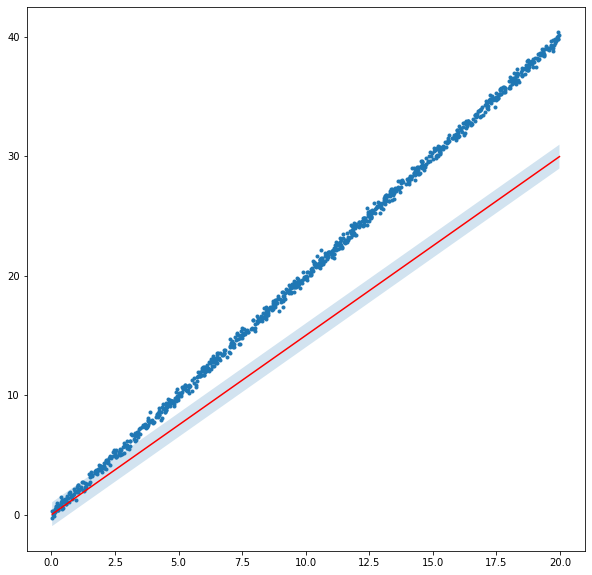

In [187]:
X, y = sample_batch(target_f1, 1000)
y_hat = (X.T @ jnp.array([beta_learned_f1])).ravel()
X_sorted, y_sorted, y_hat_sorted = sort_data(X[0], y, y_hat)

plt.figure(figsize=(10, 10))
plt.plot(X_sorted, y_sorted, '.');
plt.plot(X_sorted, y_hat_sorted, 'r');
uncertainty = [1.] * len(y_hat_sorted)
plt.fill_between(X_sorted, y_hat_sorted.copy()-uncertainty, 
                 y_hat_sorted.copy()+uncertainty, alpha=0.2);

In [18]:
beta_init = -1045.43
beta_learned_f2 = train_lin_reg(target_f2, lr=1e-5, iters= 10000, beta_init=beta_init, 
                                print_every=1000)

iteration 0, loss: 71691624.0, beta: -1045.43
iteration 1000, loss: 5025461.5, beta: -274.2817077636719
iteration 2000, loss: 333776.3125, beta: -70.99341583251953
iteration 3000, loss: 24504.873046875, beta: -17.591886520385742
iteration 4000, loss: 1766.4832763671875, beta: -3.517819881439209
iteration 5000, loss: 233.7753448486328, beta: 0.1814889758825302
iteration 6000, loss: 126.11384582519531, beta: 1.1528819799423218
iteration 7000, loss: 111.78506469726562, beta: 1.4089419841766357
iteration 8000, loss: 117.1690673828125, beta: 1.4757113456726074
iteration 9000, loss: 117.09477233886719, beta: 1.4936083555221558


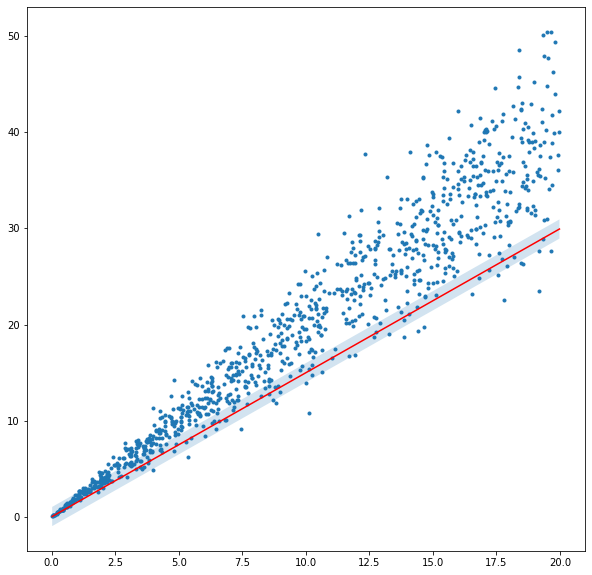

In [22]:
X, y = sample_batch(target_f2, 1000)
y_hat = (X.T @ jnp.array([beta_learned_f2])).ravel()
X_sorted, y_sorted, y_hat_sorted = sort_data(X[0], y, y_hat)

plt.figure(figsize=(10, 10))
plt.plot(X_sorted, y_sorted, '.');
plt.plot(X_sorted, y_hat_sorted, 'r');
uncertainty = [1.] * len(y_hat_sorted)
plt.fill_between(X_sorted, y_hat_sorted.copy()-uncertainty, 
                 y_hat_sorted.copy()+uncertainty, alpha=0.2);

In [23]:
beta_init = -1045.43
beta_learned_f3 = train_lin_reg(target_f3, lr=1e-5, iters= 10000, beta_init=beta_init, 
                                print_every=1000)

iteration 0, loss: 74406184.0, beta: -1045.43
iteration 1000, loss: 5119895.5, beta: -273.9351501464844
iteration 2000, loss: 352350.65625, beta: -71.02542877197266
iteration 3000, loss: 24307.197265625, beta: -17.617128372192383
iteration 4000, loss: 1910.6710205078125, beta: -3.5401694774627686
iteration 5000, loss: 218.62875366210938, beta: 0.1766642928123474
iteration 6000, loss: 124.35704040527344, beta: 1.1524779796600342
iteration 7000, loss: 114.3405990600586, beta: 1.409000277519226
iteration 8000, loss: 115.49076843261719, beta: 1.4767528772354126
iteration 9000, loss: 117.70175170898438, beta: 1.4936375617980957


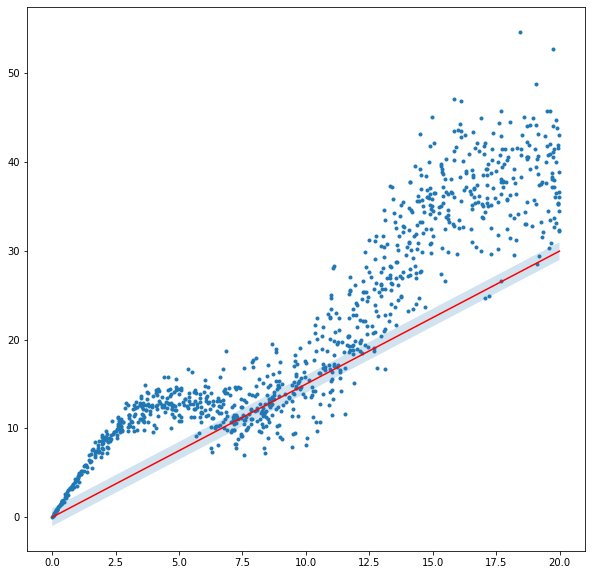

In [24]:
X, y = sample_batch(target_f3, 1000)
y_hat = (X.T @ jnp.array([beta_learned_f3])).ravel()
X_sorted, y_sorted, y_hat_sorted = sort_data(X[0], y, y_hat)

plt.figure(figsize=(10, 10))
plt.plot(X_sorted, y_sorted, '.');
plt.plot(X_sorted, y_hat_sorted, 'r');
uncertainty = [1.] * len(y_hat_sorted)
plt.fill_between(X_sorted, y_hat_sorted.copy()-uncertainty, 
                 y_hat_sorted.copy()+uncertainty, alpha=0.2);

## Fully connected neural network

In [ ]:
def neural_network(x, theta):
    w1, b1 = theta['w1'], theta['b1']
    w2, b2 = theta['w2'], theta['b2']
    
    out = jnp.tanh(x.T @ w1 + b1)
    out = out @ w2 + b2
    
    return out.ravel()

## Test model assumptions

In [72]:
theta = {'w1': randn(1, 10), 'b1': randn(10,), 'w2': randn(10, 1), 'b2': randn(1,)}
n = 100
X = randn(1, n)
assert neural_network(X, theta).shape == (100,)
print('Yaay!')

Yaay!


## Negative log-likelihood of NN model

In [93]:
def nn_model_nll(theta, X, y, sigma=1.):
    """
    This function takes the average nll loss not the sum!
    """
    return -jnp.mean(gaussian_log_likelihood(neural_network(X, theta), sigma, y))

## Training model to maximize Likelihood

In [94]:
def train_nn_reg(target_f, theta_init, bs=100, lr=1e-3, iters=1000, sigma_model=1., 
                 print_every=100):
    theta_curr = theta_init
    grad_fn = grad(nn_model_nll, argnums=0)

    for i in range(iters):
        X, y = sample_batch(target_f, bs)
        loss = nn_model_nll(theta_curr, X, y, sigma_model)
        if i % print_every == 0:
            print(f'iteration {i}, loss: {loss}')
        grad_theta = grad_fn(theta_curr, X, y, sigma_model)
        for par in theta_curr:
            theta_curr[par] -= lr * grad_theta[par]
    
    return theta_curr 

## Learn model parameters & Plot neural network regression

In [96]:
theta_init = {'w1': randn(1, 10), 'b1': randn(10,), 'w2': randn(10, 1), 'b2': randn(1,)}
theta_learned = train_nn_reg(target_f1, theta_init, iters=1000, print_every=100)

iteration 0, loss: 220.04449462890625
iteration 100, loss: 71.12371063232422
iteration 200, loss: 29.104816436767578
iteration 300, loss: 17.16596221923828
iteration 400, loss: 11.838665008544922
iteration 500, loss: 6.772592067718506
iteration 600, loss: 8.239100456237793
iteration 700, loss: 5.722941875457764
iteration 800, loss: 4.369370937347412
iteration 900, loss: 3.463486909866333


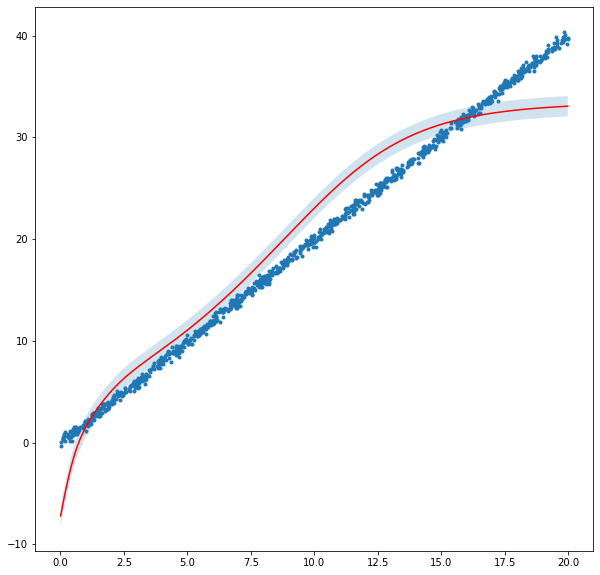

In [98]:
X, y = sample_batch(target_f1, 1000)
y_hat = neural_network(X, theta_learned)
X_sorted, y_sorted, y_hat_sorted = sort_data(X[0], y, y_hat)

plt.figure(figsize=(10, 10))
plt.plot(X_sorted, y_sorted, '.');
plt.plot(X_sorted, y_hat_sorted, 'r');
uncertainty = [1.] * len(y_hat_sorted)
plt.fill_between(X_sorted, y_hat_sorted.copy()-uncertainty, 
                 y_hat_sorted.copy()+uncertainty, alpha=0.2);

In [99]:
theta_init = {'w1': randn(1, 10), 'b1': randn(10,), 'w2': randn(10, 1), 'b2': randn(1,)}
theta_learned = train_nn_reg(target_f2, theta_init, iters=1000, print_every=100)

iteration 0, loss: 247.98292541503906
iteration 100, loss: 88.41410064697266
iteration 200, loss: 28.994701385498047
iteration 300, loss: 23.723800659179688
iteration 400, loss: 13.705881118774414
iteration 500, loss: 17.968830108642578
iteration 600, loss: 17.560117721557617
iteration 700, loss: 7.530622482299805
iteration 800, loss: 9.095466613769531
iteration 900, loss: 13.703581809997559


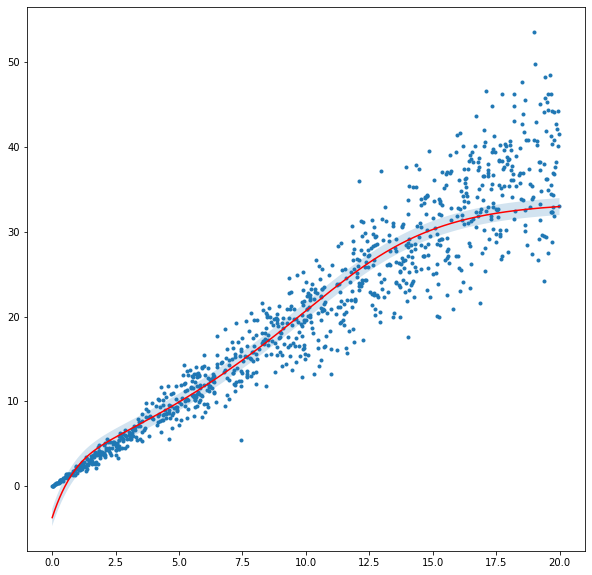

In [100]:
X, y = sample_batch(target_f2, 1000)
y_hat = neural_network(X, theta_learned)
X_sorted, y_sorted, y_hat_sorted = sort_data(X[0], y, y_hat)

plt.figure(figsize=(10, 10))
plt.plot(X_sorted, y_sorted, '.');
plt.plot(X_sorted, y_hat_sorted, 'r');
uncertainty = [1.] * len(y_hat_sorted)
plt.fill_between(X_sorted, y_hat_sorted.copy()-uncertainty, 
                 y_hat_sorted.copy()+uncertainty, alpha=0.2);

In [101]:
theta_init = {'w1': randn(1, 10), 'b1': randn(10,), 'w2': randn(10, 1), 'b2': randn(1,)}
theta_learned = train_nn_reg(target_f3, theta_init, iters=1000, print_every=100)

iteration 0, loss: 441.1163635253906
iteration 100, loss: 119.22488403320312
iteration 200, loss: 55.50416946411133
iteration 300, loss: 47.436954498291016
iteration 400, loss: 26.962018966674805
iteration 500, loss: 25.948808670043945
iteration 600, loss: 19.466827392578125
iteration 700, loss: 28.614656448364258
iteration 800, loss: 11.878596305847168
iteration 900, loss: 30.833663940429688


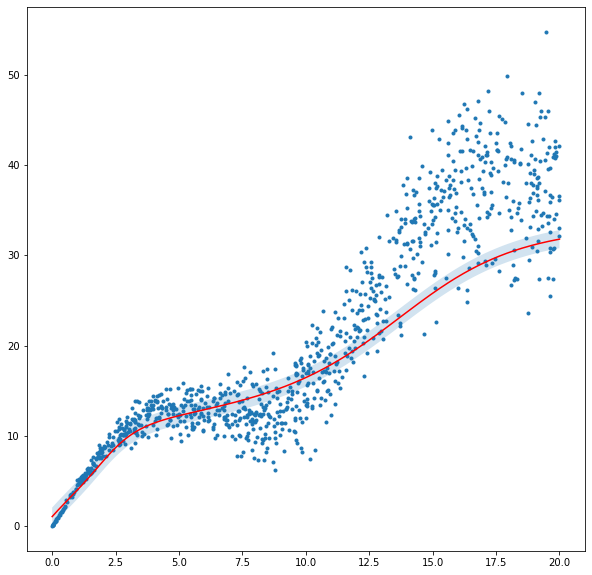

In [102]:
X, y = sample_batch(target_f3, 1000)
y_hat = neural_network(X, theta_learned)
X_sorted, y_sorted, y_hat_sorted = sort_data(X[0], y, y_hat)

plt.figure(figsize=(10, 10))
plt.plot(X_sorted, y_sorted, '.');
plt.plot(X_sorted, y_hat_sorted, 'r');
uncertainty = [1.] * len(y_hat_sorted)
plt.fill_between(X_sorted, y_hat_sorted.copy()-uncertainty, 
                 y_hat_sorted.copy()+uncertainty, alpha=0.2);

## Input dependent variance

In [120]:
def neural_net_w_var(x, theta):
    w1, b1 = theta['w1'], theta['b1']
    w2, b2 = theta['w2'], theta['b2']
    
    out = jnp.tanh(x.T @ w1 + b1)
    out = out @ w2 + b2
    
    mean = out[:, 0]
    log_sigma = out[:, 1]
    
    return mean, log_sigma

## Test model assumptions

In [121]:
theta_init = {'w1': randn(1, 10), 'b1': randn(10,), 'w2': randn(10, 2), 'b2': randn(2,)}
n = 100
X, y = sample_batch(target_f1, n)

mean, log_sigma = neural_net_w_var(X, theta_init)
assert mean.shape == (100,)
assert log_sigma.shape == (100,)

print('Yaay!')

Yaay!


## Negative log-likelihood with modelled variance

In [130]:
def nn_with_var_model_nll(theta, x, y):
    mean, log_sigma = neural_net_w_var(x, theta)
    return -jnp.mean(gaussian_log_likelihood(mean, jnp.exp(log_sigma), y))

## Write training loop

In [131]:
def train_nn_w_var_reg(target_f, theta_init, bs=100, lr=1e-4, iters=10000, print_every=10):
    theta_curr = theta_init
    grad_fn = grad(nn_with_var_model_nll, argnums=0)
    
    for i in range(iters):
        X, y = sample_batch(target_f, bs)
        loss = nn_with_var_model_nll(theta_curr, X, y)
        if i % print_every == 0:
            print(f'iteration {i}, loss: {loss}')
        grad_theta = grad_fn(theta_curr, X, y)
        for par in theta_curr:
            theta_curr[par] -= lr * grad_theta[par]
    
    return theta_curr 

## Learn model with input-dependent variance & Plot model

In [135]:
theta_init = {'w1': randn(1, 10), 'b1': randn(10,), 'w2': randn(10, 2), 'b2': randn(2,)}
theta_learned = train_nn_w_var_reg(target_f1, theta_init, iters=100, print_every=1, 
                                   lr=1e-5, bs=20)

iteration 0, loss: 6.1469855308532715
iteration 1, loss: 6.3770670890808105
iteration 2, loss: 6.412261962890625
iteration 3, loss: 6.3650312423706055
iteration 4, loss: 6.1991376876831055
iteration 5, loss: 6.392675399780273
iteration 6, loss: 6.423218727111816
iteration 7, loss: 6.210007667541504
iteration 8, loss: 6.176400184631348
iteration 9, loss: 6.1655354499816895
iteration 10, loss: 6.075665473937988
iteration 11, loss: 6.4684295654296875
iteration 12, loss: 6.28631067276001
iteration 13, loss: 6.374464988708496
iteration 14, loss: 5.993732452392578
iteration 15, loss: 6.24228048324585
iteration 16, loss: 5.951014518737793
iteration 17, loss: 6.450488090515137
iteration 18, loss: 6.273338794708252
iteration 19, loss: 6.229282379150391
iteration 20, loss: 6.4006242752075195
iteration 21, loss: 6.208463668823242
iteration 22, loss: 6.12829065322876
iteration 23, loss: 5.999441146850586
iteration 24, loss: 6.1018171310424805
iteration 25, loss: 6.107501029968262
iteration 26, los